In [77]:
# -*- coding: utf-8 -*-
# -*- author : Lokman Mheni - Fabio Palmisano -*-
# -*- date : 2024-04-20 -*-
# -*- Last revision: 2024-06-10 *-
# -*- python version : 3.11.9 -*-
# -*- Description: Simple Model Book-to-Book (to read)-*-

# <center> EE - 452: Network Machine Learning </center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center>Bookreads recommenders </center>
---

In [97]:
# Importing the libraries
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
from itertools import combinations
from collections import defaultdict
from tqdm import tqdm


from grakel import GraphKernel
from grakel.utils import graph_from_networkx
from tqdm import tqdm

# Imports for Model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier


seed = 42


# Import Datasets
tr = pd.read_csv( 'data/to_read.csv' )
r = pd.read_csv( 'data/ratings.csv' )

## Previous Analysis 
---

In [44]:
tr.head()

,user_id,book_id
0,9,8
1,15,398
2,15,275
3,37,7173
4,34,380


In [47]:
# Summary DataFrame wiht Number of ratings, average rating,
#  to read count and percentage of to read

r['book_id'].value_counts()
r.groupby('book_id')['rating'].mean()
ratings = pd.DataFrame( r['book_id'].value_counts() )
ratings.columns = ['n_ratings']
ratings['avg_rating'] = r.groupby('book_id')['rating'].mean()
ratings['book_id'] = ratings.index
ratings = ratings.reset_index( drop = True )

to_read_counts = tr['book_id'].value_counts()
ratings['to_read_count'] = ratings['book_id'].map(to_read_counts)
ratings['to_read_count'] = ratings['to_read_count'].fillna(0)
ratings['to_read_count'] = ratings['to_read_count'].astype(int)

ratings["perc_to_read"] = (ratings["to_read_count"] / ratings["n_ratings"])*100

ratings

,n_ratings,avg_rating,book_id,to_read_count,perc_to_read
0,22806,4.279707,1,973,4.266421
1,21850,4.351350,2,400,1.830664
2,19088,4.329369,4,1478,7.743085
3,16931,3.214341,3,287,1.695115
4,16604,3.772224,5,1293,7.787280
...,...,...,...,...,...
9995,36,3.722222,9315,17,47.222222
9996,33,3.757576,1935,5,15.151515
9997,24,4.041667,9486,2,8.333333
9998,11,3.545455,9345,1,9.090909


In [48]:
# Some stats about percentage of to read books
ratings["perc_to_read"].describe()


count    10000.000000
mean        19.770630
std         17.715757
min          0.000000
25%          7.586207
50%         14.881943
75%         26.027901
max        268.456376
Name: perc_to_read, dtype: float64

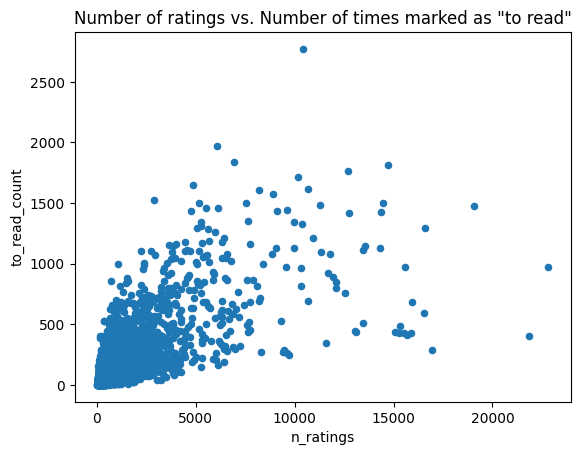

Correlation =  0.7292942930615238


In [50]:
# Correlation between the number of times a book is marked as "to read" and 
# the number of ratings
ratings.plot.scatter( x = 'n_ratings', y = 'to_read_count' )
plt.title( 'Number of ratings vs. Number of times marked as "to read"' )
plt.show()

correlation = ratings['to_read_count'].corr(ratings['n_ratings'])
print("Correlation = ", correlation)

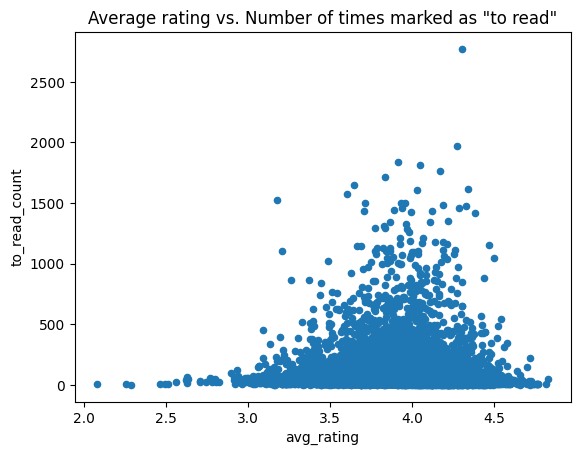

Correlation =  0.0036904096044729907


In [51]:
# Correlation between the average rating of a book and 
# the number of times it has been marked as "to read"
ratings.plot.scatter( x = 'avg_rating', y = 'to_read_count' )
plt.title( 'Average rating vs. Number of times marked as "to read"' )
plt.show()

correlation = ratings['to_read_count'].corr(ratings['avg_rating'])
print("Correlation = ", correlation)

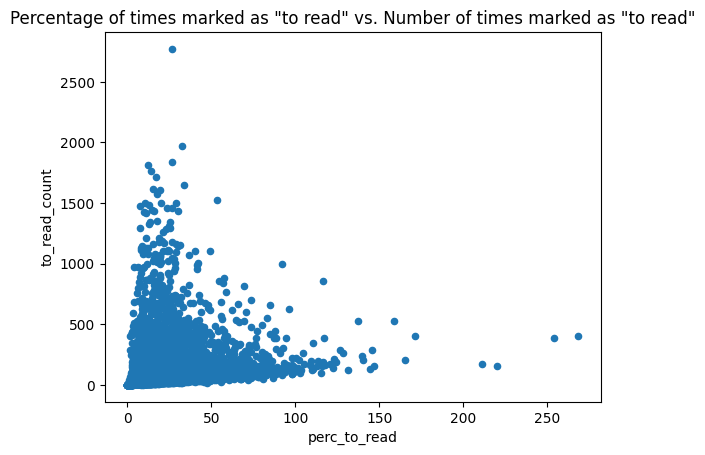

Correlation =  0.2242995370619817


In [52]:
# Correlation between percentage of times a book is marked as "to read" 
# and the number of times it has been marked to read 
ratings.plot.scatter( x = 'perc_to_read', y = 'to_read_count' )
plt.title( 'Percentage of times marked as "to read" vs. Number of times marked as "to read"' )
plt.show()

correlation = ratings['to_read_count'].corr(ratings['perc_to_read'])
print("Correlation = ", correlation)

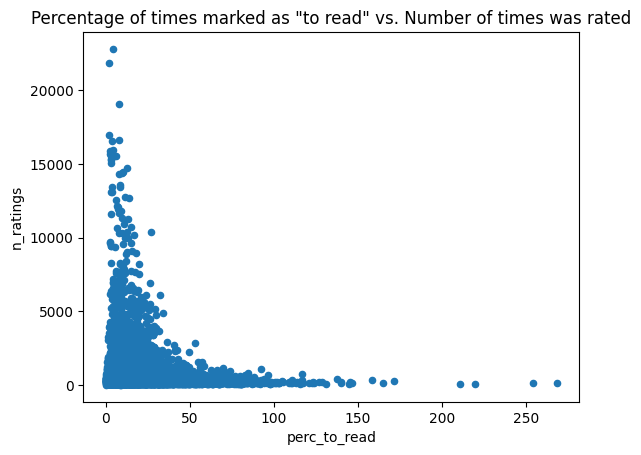

Correlation =  -0.11977616908195686


In [53]:
#And now we want to see if there is a correlation between percentage of times a book is marked as "to read" and the number of times it has been marked to read 
ratings.plot.scatter( x = 'perc_to_read', y = 'n_ratings' )
plt.title( 'Percentage of times marked as "to read" vs. Number of times was rated' )
plt.show()

correlation = ratings['n_ratings'].corr(ratings['perc_to_read'])
print("Correlation = ", correlation)

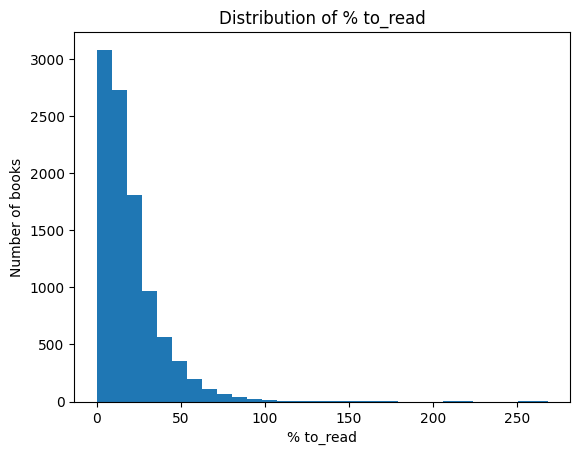

In [13]:
#Plot the distribution of the %  to_read 
plt.hist(ratings["% to_read"], bins = 30)
plt.xlabel('% to_read')
plt.ylabel('Number of books')
plt.title('Distribution of % to_read')
plt.show()


---
## Graph Creation 

In [61]:
# Create a dictionary where the keys are user_ids and the values are sets of book_ids
user_books = defaultdict(set)

for _, row in tqdm(tr.iterrows(), total=tr.shape[0]):
    user_books[row['user_id']].add(row['book_id'])


100%|██████████| 912705/912705 [00:18<00:00, 50047.61it/s]


In [62]:
# Cretion of the graph based on the user_books dictionary 
# and users are randomly sampled
user_subset = random.sample(list(user_books.keys()), 1000)

G_user_books_sample = nx.Graph()

for user_id in tqdm(user_subset, total=len(user_subset)):
    books = user_books[user_id]
    book_pairs = combinations(books, 2)
    for book_pair in book_pairs:
        G_user_books_sample.add_edge(*book_pair, user_id=user_id)

print("Number of Node : ",len(G_user_books_sample.nodes()))
print("Number of Edges : ",len(G_user_books_sample.edges()))

100%|██████████| 1000/1000 [00:00<00:00, 2856.33it/s]

Number of Node :  5669
Number of Edges :  267667


---
## Graph Creation 

In [84]:
number_to_read =  tr['book_id'].value_counts()
number_to_read

book_id
47      2772
143     1967
113     1840
13      1812
11      1767
        ... 
6297       1
7951       1
4434       1
9124       1
8946       1
Name: count, Length: 9986, dtype: int64

In [85]:
# With the Arbitrary threshold definition 
threshold_Bestseller = 50
number_to_read = number_to_read.apply(lambda x: 1 if x >= threshold_Bestseller else 0)
number_to_read

book_id
47      1
143     1
113     1
13      1
11      1
       ..
6297    0
7951    0
4434    0
9124    0
8946    0
Name: count, Length: 9986, dtype: int64

In [86]:
number_to_read.value_counts()

count
0    5641
1    4345
Name: count, dtype: int64

In [87]:
# Add Label to nodes
nx.set_node_attributes(G_user_books_sample, number_to_read.to_dict(), 'to_read')

In [88]:
#check in G_user_books_sample the proportion of nodes set to label 1 (to read) and which are set to 0 (not to read)
to_read = 0
not_to_read = 0
for node in G_user_books_sample.nodes(data=True):
    if node[1].get('to_read', 0) == 1:
        to_read += 1
    else:
        not_to_read += 1
print(to_read, not_to_read)

3744 1925


In [91]:
graph_labels = nx.get_node_attributes(G_user_books_sample, 'to_read')


---
## Graph Training

### Logistic Regression (using properties of graph as features)

In [94]:
#Node Features is creating and then is fullfill with all the properties of the graph considered. 
node_features = pd.DataFrame(index=G_user_books_sample.nodes())

# Calculate the degree 
node_features['degree'] = pd.Series(dict(G_user_books_sample.degree()))

# Calculate the degree centrality 
node_features['degree_centrality'] = pd.Series(nx.degree_centrality(G_user_books_sample))

# Calculate the closeness centrality 
node_features['closeness'] = pd.Series(nx.closeness_centrality(G_user_books_sample))

# Calculate the betweenness centrality 
node_features['betweenness'] = pd.Series(nx.betweenness_centrality(G_user_books_sample))

#Calculate the clustering coefficient 
node_features['clustering'] = pd.Series(nx.clustering(G_user_books_sample))

# Calculate the eigenvector centrality 
node_features['eigenvector'] = pd.Series(nx.eigenvector_centrality(G_user_books_sample))

# Calculate the pagerank 
node_features['pagerank'] = pd.Series(nx.pagerank(G_user_books_sample))

# Calculate the average neighbor degree 
node_features['average_neighbor_degree'] = pd.Series(nx.average_neighbor_degree(G_user_books_sample))

# Merge the node features with the graph labels
node_features = node_features.merge(pd.Series(graph_labels, name ='graph_labels'), left_index=True, right_index=True)

# Split in train/test and train the model 
X_train, X_test, y_train, y_test = train_test_split(node_features.drop('graph_labels', axis=1), node_features['graph_labels'], test_size=0.3, random_state=seed)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(y_pred)


# Results 
accuracy_score(y_test, y_pred)
f1_score(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

pd.DataFrame({'Real': y_test, 'Predicted': y_pred})


[1 1 1 ... 1 0 1]
Accuracy:  0.7436801881246325
F1 Score:  0.802536231884058


,Real,Predicted
1286,1,1
7337,0,1
1055,1,1
8916,1,1
4731,0,0
...,...,...
2761,1,1
2058,1,1
1265,1,1
2010,1,0


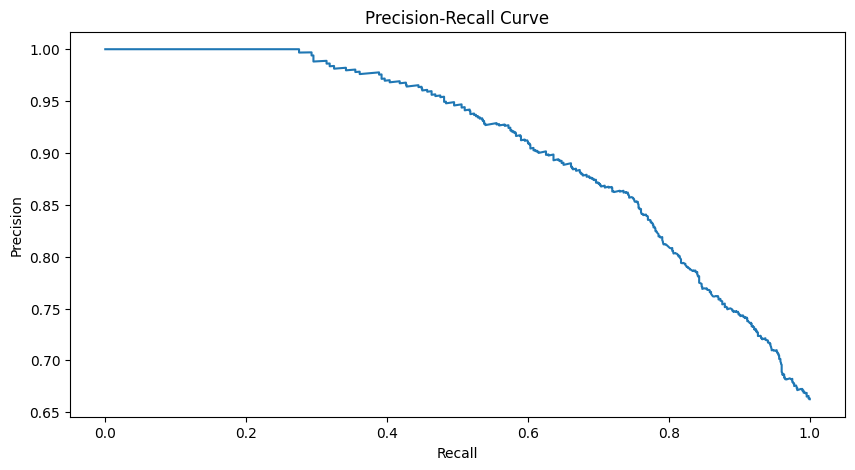

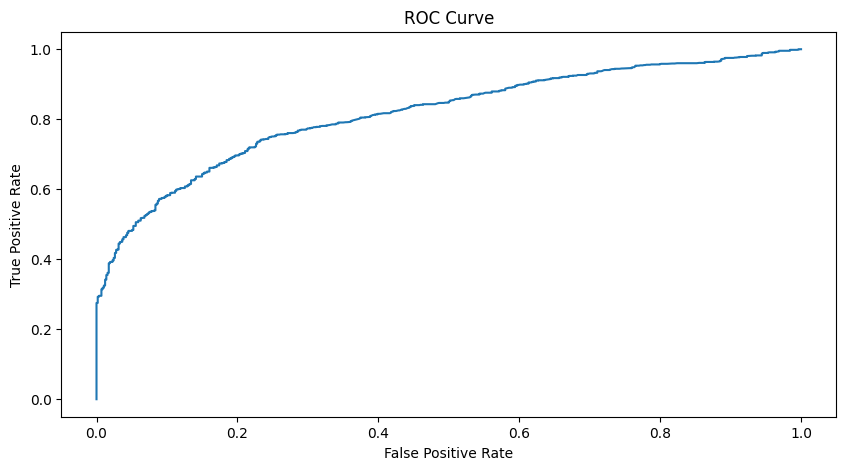

In [98]:
# Plot the Precision Recall Curve 
y_scores = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
f1_scores = 2*recall*precision / (recall + precision)
best_threshold = thresholds[np.argmax(f1_scores)]
y_pred = (y_scores > best_threshold).astype(int)
 
plt.figure(figsize=(10, 5))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Find the bests features

In [99]:
# Now can we try to make different combinaisons of features to see what has the best accuracy and F1 score and store the result in a datafram in order to print the best combinaison
from sklearn.metrics import f1_score

results = pd.DataFrame(columns=['features', 'accuracy', 'f1_score'])

# Iterate over all possible combinations of features
for i in range(1, len(node_features.columns) - 1):
    for features in combinations(node_features.columns[:-1], i):
        print(features)
        X_train, X_test, y_train, y_test = train_test_split(node_features[list(features)], node_features['graph_labels'], test_size=0.3, random_state=seed)
        model = LogisticRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results.loc[len(results)] = [features, accuracy, f1]
        print(accuracy, f1)

results.sort_values('f1_score', ascending=False).head(10)

best_combinaison = results.sort_values('f1_score', ascending=False).iloc[0]
print("Best combinaison of features:")
print(best_combinaison['features'])
print("Accuracy:", best_combinaison['accuracy'])
print("F1 Score:", best_combinaison['f1_score'])


('degree',)
0.7172251616696061 0.7925830099180681
('degree_centrality',)
0.6625514403292181 0.7970297029702971
('closeness',)
0.7142857142857143 0.8122102009273571
('betweenness',)
0.6625514403292181 0.7970297029702971
('clustering',)
0.7495590828924162 0.7990566037735849
('eigenvector',)
0.6625514403292181 0.7970297029702971
('pagerank',)
0.6625514403292181 0.7970297029702971
('average_neighbor_degree',)
0.6801881246325691 0.8013148283418553
('degree', 'degree_centrality')
0.7172251616696061 0.7925830099180681
('degree', 'closeness')
0.7142857142857143 0.7914163090128755
('degree', 'betweenness')
0.7172251616696061 0.7925830099180681
('degree', 'clustering')
0.7507348618459729 0.8056828597616865
('degree', 'eigenvector')
0.7172251616696061 0.7925830099180681
('degree', 'pagerank')
0.7172251616696061 0.7925830099180681
('degree', 'average_neighbor_degree')
0.721928277483833 0.7972567509644235
('degree_centrality', 'closeness')
0.7148736037624926 0.8119426134160527
('degree_centrality',

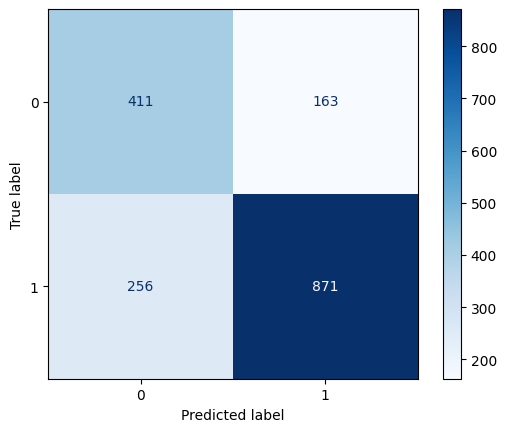

In [100]:
#Plot the confusion Matrix with the best features
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.show()

### Random Forest (with best features)

In [104]:
X_train, X_test, y_train, y_test = train_test_split(node_features[list(best_combinaison['features'])], node_features['graph_labels'], test_size=0.3, random_state=seed)

model = RandomForestClassifier(random_state=seed)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)


print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))

Accuracy:  0.7389770723104057
F1 Score:  0.8049209138840069


### Random Forest (with all features)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(node_features.drop('graph_labels', axis=1), node_features['graph_labels'], test_size=0.3, random_state=seed)

model = RandomForestClassifier(random_state=seed)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)

f1_score(y_test, y_pred)

# Print the results
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

pd.DataFrame({'Real': y_test, 'Predicted': y_pred})

Accuracy:  0.7483833039388595
F1 Score:  0.814236111111111


,Real,Predicted
1286,1,1
7337,0,0
1055,1,1
8916,1,1
4731,0,0
...,...,...
2761,1,1
2058,1,1
1265,1,1
2010,1,0


### SVM (with all features)

In [105]:
#Try with SVM
from sklearn.svm import SVC

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(node_features.drop('graph_labels', axis=1), node_features['graph_labels'], test_size=0.3, random_state=seed)

# Train a simple model
model = SVC(probability=True)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

print(y_pred)
# Calculate the accuracy of the model
accuracy_score(y_test, y_pred)

#F1 score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

# Print the results
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))


# Print the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

pd.DataFrame({'Real': y_test, 'Predicted': y_pred})

[1 1 1 ... 1 0 1]
Accuracy:  0.7184009406231628
F1 Score:  0.8067769261799113


,Real,Predicted
1286,1,1
7337,0,1
1055,1,1
8916,1,1
4731,0,0
...,...,...
2761,1,1
2058,1,1
1265,1,1
2010,1,0
